In [8]:
import pandas as pd
from pandas.api.types import CategoricalDtype as Category
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import numpy as np
from iterextras import par_for
import subprocess as sp
import os
import itertools
from tqdm.auto import tqdm
import rs_utils

sns.set()

In [9]:
def cond(df, m=None, c=None, p=None):
    if m is not None:
        df = df[df.mutability_mode == m]
    if c is not None:
        df = df[df.context_mode == c]
    if p is not None:
        df = df[df.pointer_mode == p]
    return df

In [10]:
PATHS = glob('../data/*.json')
CRATES = [os.path.splitext(os.path.basename(path))[0] for path in PATHS]
CATEGORIES = {
    'mutability_mode': Category(["DistinguishMut", "IgnoreMut"]),
    'context_mode': Category(["Recurse", "SigOnly"]),
    'pointer_mode': Category(["Conservative", "Precise"]),
    'crate': Category(CRATES)
}

def parse_data(path):
    print(path)
    if os.stat(path).st_size == 0:
        return []
    
    crate = os.path.splitext(os.path.basename(path))[0]
    df = pd.DataFrame(rs_utils.parse_data(path))
    df['crate'] = crate
    for k, dt in CATEGORIES.items():
        df[k] = df[k].astype(dt)
    return df


all_dfs = par_for(parse_data, PATHS)
df = pd.concat(all_dfs).reset_index()
del all_dfs

# df = df[(df.num_relevant_instructions != 0)]
df['ins_rel_nonzero'] = df.instructions_relative > 0

../data/hyper.json../data/image.json

../data/RustPython.json
../data/rg3d.json
../data/rayon.json
../data/rustls.json
../data/Rocket.json
../data/nalgebra.json
../data/sccache.json


  0%|          | 0/9 [00:00<?, ?it/s]

In [11]:
len(df.function_path.unique())

13765

In [12]:
len(df)/8

349380.0

In [13]:
df['ins_rel_frac_log'] = np.log(df.instructions_relative_frac)

/raid/wcrichto/flowistry-experiments/.env/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [25]:
df2 = cond(df, m='DistinguishMut', c='Recurse', p='Precise')
row = df2[df2.instructions_relative_frac > 0].iloc[0]
(row.function_path, row.sliced_local)

('nalgebra[aca9]::linalg::cholesky::{impl#2}::xx_rank_one_update', 110)

In [26]:
df[(df.function_path == 'nalgebra[aca9]::linalg::cholesky::{impl#2}::xx_rank_one_update') & (df.sliced_local == 110)]

,index,mutability_mode,context_mode,pointer_mode,sliced_local,function_range,function_path,num_instructions,num_relevant_instructions,duration,...,has_same_type_ptrs_in_input,reached_library,instructions_relative,instructions_relative_frac,instructions_relative_base,instructions_relative_base_frac,baseline_reached_library,crate,ins_rel_nonzero,ins_rel_frac_log
2473888,173832,DistinguishMut,Recurse,Precise,110,"{'start': 12481, 'end': 14368, 'filename': 'sr...",nalgebra[aca9]::linalg::cholesky::{impl#2}::xx...,169,52,0.000011,...,False,False,30,1.363636,30,1.363636,False,nalgebra,True,0.310155
2473889,173833,DistinguishMut,Recurse,Conservative,110,"{'start': 12481, 'end': 14368, 'filename': 'sr...",nalgebra[aca9]::linalg::cholesky::{impl#2}::xx...,169,55,0.000009,...,False,False,33,1.500000,33,1.500000,False,nalgebra,True,0.405465
2473890,173834,DistinguishMut,SigOnly,Precise,110,"{'start': 12481, 'end': 14368, 'filename': 'sr...",nalgebra[aca9]::linalg::cholesky::{impl#2}::xx...,169,22,0.001180,...,False,False,0,0.000000,0,0.000000,False,nalgebra,False,-inf
2473891,173835,DistinguishMut,SigOnly,Conservative,110,"{'start': 12481, 'end': 14368, 'filename': 'sr...",nalgebra[aca9]::linalg::cholesky::{impl#2}::xx...,169,67,0.001324,...,False,False,45,2.045455,45,2.045455,False,nalgebra,True,0.715620
2473892,173836,IgnoreMut,Recurse,Precise,110,"{'start': 12481, 'end': 14368, 'filename': 'sr...",nalgebra[aca9]::linalg::cholesky::{impl#2}::xx...,169,52,0.000009,...,False,False,30,1.363636,30,1.363636,False,nalgebra,True,0.310155
2473893,173837,IgnoreMut,Recurse,Conservative,110,"{'start': 12481, 'end': 14368, 'filename': 'sr...",nalgebra[aca9]::linalg::cholesky::{impl#2}::xx...,169,69,0.000008,...,False,False,47,2.136364,47,2.136364,False,nalgebra,True,0.759105
2473894,173838,IgnoreMut,SigOnly,Precise,110,"{'start': 12481, 'end': 14368, 'filename': 'sr...",nalgebra[aca9]::linalg::cholesky::{impl#2}::xx...,169,25,0.001252,...,False,False,3,0.136364,3,0.136364,False,nalgebra,True,-1.992430
2473895,173839,IgnoreMut,SigOnly,Conservative,110,"{'start': 12481, 'end': 14368, 'filename': 'sr...",nalgebra[aca9]::linalg::cholesky::{impl#2}::xx...,169,78,0.001353,...,False,False,56,2.545455,56,2.545455,False,nalgebra,True,0.934309


# Dataset summary

In [14]:
#df2 = df.groupby(['crate', 'function_path']).apply(compute_loc)#.groupby('crate').sum()
g = df2.reset_index().groupby('crate')
out = g.sum()
out['size'] = g.size()
out

NameError: name 'df2' is not defined

## Execution time

In [15]:
df2 = cond(df, m='DistinguishMut', c='SigOnly', p='Precise')
print(df2.duration.max(), df2.duration.median() * 100000)


4.765184637299998 45.149930000000005


In [16]:
df2 = cond(df, m='IgnoreMut', c='Recurse', p='Conservative')
print(df2.duration.max(), df2.duration.median() * 100000)

145.61315227459994 2731.6321900000003


## Number of instructions

In [ ]:
ax = sns.histplot(df.num_instructions)
# ax.set_xscale('log')

In [ ]:
df_big = df[df.num_instructions >= 1000]
len(df_big) / len(df)

# Slice size analysis

In [17]:
def plot_ins(data, xscale='linear', yscale='linear', field='instructions_relative_frac', nz=True, ax=None, **kwargs):
    if xscale == 'log':
        df_plot = data[data.ins_rel_nonzero]
        bins = np.logspace(np.log10(0.00001), np.log10(df_plot[field].max()))
    elif xscale == 'symlog':
        df_plot = data
        min_n = df_plot[df_plot[field] > 0][field].min()/10
        bins = np.concatenate(([0], np.logspace(np.log10(min_n), np.log10(df_plot[field].max()))))
    else:
        df_plot = data
        n = df_plot.instructions_relative_frac.max()
        bins = np.arange(0, n, n / 50)
        
    ax = sns.histplot(df_plot[field], bins=bins, ax=ax) #element='step')
    ax.set_yscale(yscale)
    if xscale == 'symlog':
        ax.set_xscale(xscale, linthresh=min_n, linscale=0.2)
    else:
        ax.set_xscale(xscale)
        
    ax.set_xlabel('\% diff in slice size' + (', log scale' if 'log' in xscale else ''))
    ax.set_ylabel('Count' + (', log scale' if yscale == 'log' else ''))
    
    if xscale == 'log' and nz:
        n = data[data.ins_rel_nonzero][field].min() / 10
        ax.bar(n, len(data[~data.ins_rel_nonzero]), color='r', width=[n])
    elif xscale == 'symlog':
        ax.set_xlim(0)
        xticks = ax.get_xticks()
        ax.set_xticks(np.concatenate((xticks[0:1], xticks[3:])))
        
plot_ins_nz = lambda *args, **kwargs: plot_ins(*args, xscale='log', yscale='linear', nz=False, **kwargs)
plot_ins_abs = lambda *args, **kwargs: plot_ins(*args, field='instructions_relative', **kwargs)

# plot_ins(df, 'symlog', 'log')

/raid/wcrichto/flowistry-experiments/.env/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


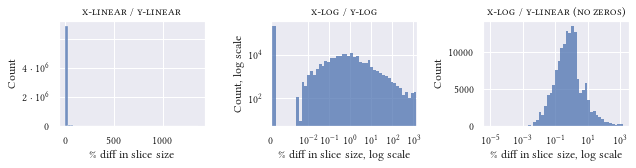

In [18]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Linux Libertine O']})
rc('text', **{'usetex': True, 'latex.preamble': r'\usepackage{libertine}\usepackage[libertine]{newtxmath}'})

df2 = cond(df, c='SigOnly', m='DistinguishMut', p='Precise')
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(9, 2.5))
plot_ins(df2, ax=ax1)
ax1.set_title('\\textsc{x-linear / y-linear}')
ax1.set_yticklabels(['0', '$2 \cdot 10^6$', '$4 \cdot 10^6$'])

plot_ins(df2, xscale='symlog', yscale='log', ax=ax2)
ax2.set_title('\\textsc{x-log / y-log}')
plot_ins(df2, xscale='log', nz=False, ax=ax3)
ax3.set_title('\\textsc{x-log / y-linear (no zeros)}')
ax3.set_xticks([10e-6, 10e-4, 10e-2, 10e-0, 10e2])

# fig.suptitle('Distribution of slice \%diff for SigOnly vs. Recurse')
fig.tight_layout()
fig.savefig('eval-recurse-dist.pdf')

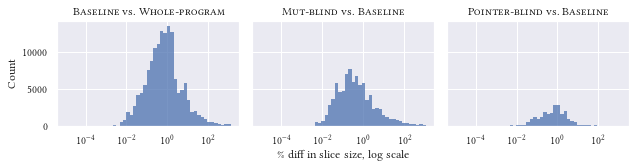

In [19]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(9, 2.5), sharey=True)

plot_ins(cond(df, c='SigOnly', m='DistinguishMut', p='Precise'), xscale='log', nz=False, ax=ax1)
ax1.set_title('\\textsc{Baseline} vs. \\textsc{Whole-program}')
plot_ins(cond(df, c='SigOnly', m='IgnoreMut', p='Precise'), field='instructions_relative_base_frac', 
         xscale='log', nz=False, ax=ax2)
ax2.set_title('\\textsc{Mut-blind} vs. \\textsc{Baseline}')
plot_ins(cond(df, c='SigOnly', m='DistinguishMut', p='Conservative'), field='instructions_relative_base_frac', 
         xscale='log', nz=False, ax=ax3)
ax3.set_title('\\textsc{Pointer-blind} vs. \\textsc{Baseline}')

ax1.set_xlabel('')
ax3.set_xlabel('')

fig.tight_layout()

fig.savefig('eval-all-dist.pdf')

In [20]:
df2 = cond(df, c='SigOnly', m='IgnoreMut', p='Precise')
g = df2[df2.instructions_relative_base_frac > 0].groupby('crate').size().rename('nz')
g2 = pd.concat([
    g, 
    df2.groupby('crate').size().rename('total'), 
    df2.groupby('crate').num_instructions.median().rename('avg_ins')], axis=1)
g2['frac'] = g2.nz / g2.total
g2.sort_values('frac')

,nz,total,avg_ins,frac
crate,,,,
rayon,762,10695,24.0,0.071248
image,5966,40658,133.0,0.146736
Rocket,2055,12615,75.0,0.162901
rg3d,10667,60841,85.0,0.175326
RustPython,20073,99022,113.0,0.202713
rustls,5453,23685,108.0,0.230230
sccache,7924,24677,203.0,0.321109
nalgebra,12028,37196,80.0,0.323368
hyper,20493,39991,562.0,0.512440


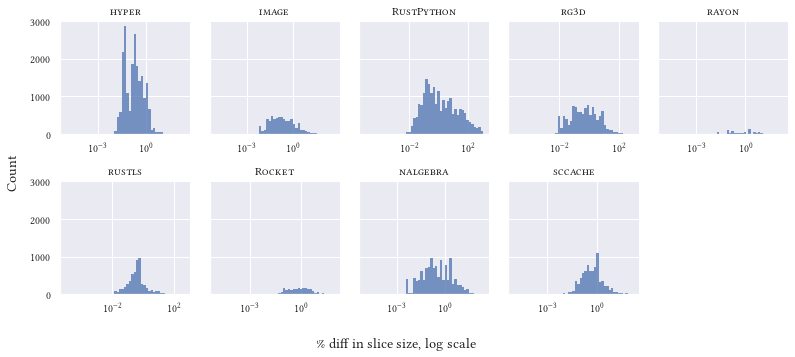

In [21]:
g = sns.FacetGrid(data=cond(df, c='SigOnly', m='IgnoreMut', p='Precise'), 
                  col='crate', col_wrap=5, sharex=False, height=2.5, aspect=0.9)
g.map_dataframe(plot_ins, xscale='log', nz=False, field='instructions_relative_base_frac')
g.set_titles('\\textsc{{{col_name}}}')
g.fig.supylabel('Count')
g.fig.supxlabel('\% diff in slice size, log scale')
g.fig.tight_layout()
g.fig.savefig('eval-crates.pdf')

In [ ]:
from scipy.stats.mstats import gmean

df2 = cond(df, c='SigOnly', m='IgnoreMut', p='Precise')
nz = df2[df2.instructions_relative_base_frac > 0]
print(len(nz) / len(df2), gmean(nz.instructions_relative_base_frac))

In [ ]:
df2 = cond(df, c='SigOnly', m='DistinguishMut', p='Conservative')
nz = df2[df2.instructions_relative_base_frac > 0]
print(len(nz) / len(df2), gmean(nz.instructions_relative_base_frac))

In [ ]:
cond(df, c='Recurse', m='DistinguishMut', p='Precise').groupby('reached_library').num_instructions.describe()

In [ ]:
140427 / (140427 + 276530)

In [ ]:
cond(df, c='SigOnly', m='DistinguishMut', p='Precise').groupby(['reached_library', 'ins_rel_nonzero']) \
    .instructions_relative_frac.describe()[['count', 'mean', '50%']]

In [ ]:
print(732 / 139695)
print(18267.0 / 258263.0)

In [ ]:
# df2 = cond(df, c='SigOnly', m='DistinguishMut', p='Precise')
# df3 = df2.groupby(['crate', 'function_path']) \
#     .apply(lambda df: df.iloc[0]).reset_index(drop=True)
num_slices = df2.groupby(['crate']).size().rename('num_slices')
avg_ins_per_func = df3.groupby('crate').num_instructions.mean() \
    .rename('avg_ins_per_func')
num_funcs = df2.groupby(['crate']).size().rename('num_funcs')

q = df2.groupby(['crate', 'function_path']).size()
avg_slices_per_func = q[q > 0] \
    .groupby('crate').mean().rename('avg_slices_per_func')
pd.concat(
    [num_slices, avg_ins_per_func, num_funcs, avg_slices_per_func], 
    axis=1).sort_values('num_slices')